In [5]:
pip install -U finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 8.1 MB/s eta 0:00:00


In [39]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score

stock_code, stock_name = '005930', '삼성전자'

# 삼성전자(005930) 주식 데이터 불러오기
df = fdr.DataReader(stock_code, '2020-01-01', '2024-08-19')

# 상한가 이후 10영업일 간의 데이터와 라벨링을 위한 전처리
def create_dataset(df):
    X, y = [], []
    for i in range(len(df) - 10):
        # 상한가 이후 10일간의 데이터를 추출
        ten_day_data = df.iloc[i:i+10].copy()
        # 상한가 대비 10일간 최고가의 5% 이상 상승 여부를 라벨로 설정
        high_price = ten_day_data['High'].max()
        if high_price >= df['Close'].iloc[i] * 1.05:
            label = 1
        else:
            label = 0
        X.append(ten_day_data[['Open', 'High', 'Low', 'Close', 'Volume']].values)
        y.append(label)
    return np.array(X), np.array(y)

# 데이터셋 생성
X, y = create_dataset(df)

# 데이터 스케일링
scaler = MinMaxScaler()
X = X.reshape(-1, X.shape[-1])
X = scaler.fit_transform(X)
X = X.reshape(-1, 10, X.shape[-1])

# 학습 및 테스트 데이터 분리
x_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 딥러닝 모델 구성
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, epochs=100, batch_size=16, validation_split=0.2)

# 모델 평가
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# 정확도, f1 스코어 계산
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy)
print("F1 Score:", f1)

# 학습 과정 중 val_acc 확인
val_acc = max(history.history['val_accuracy'])
print("Best Validation Accuracy:", val_acc)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6961 - loss: 0.6246 - val_accuracy: 0.6484 - val_loss: 0.6502
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7307 - loss: 0.5776 - val_accuracy: 0.6484 - val_loss: 0.6579
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7234 - loss: 0.5841 - val_accuracy: 0.6484 - val_loss: 0.6335
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7260 - loss: 0.5795 - val_accuracy: 0.6484 - val_loss: 0.6380
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7307 - loss: 0.5747 - val_accuracy: 0.6484 - val_loss: 0.6337
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7196 - loss: 0.5747 - val_accuracy: 0.6484 - val_loss: 0.6614
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7337 - loss: 0.5691 - val_accuracy: 0.6484 - val_loss: 0.6351
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7136 - loss: 0.5918 - val_accuracy: 0.6538 - val_l

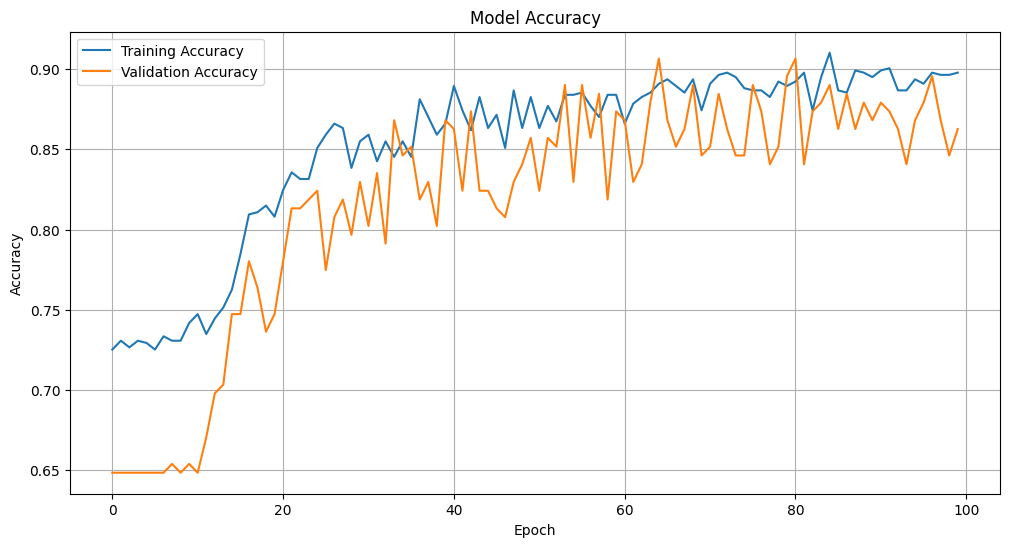

In [40]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 6))

# 정확도
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# 그래프 제목과 라벨
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
# 모델 저장
model.save('stock_prediction_model.h5')

In [42]:
def create_future_dataset(df):
    X, y = [], []
    for i in range(len(df) - 10):
        # 현재 시점부터 10일간의 데이터를 추출
        ten_day_data = df.iloc[i:i+10].copy()
        # 10일 후의 종가를 현재 종가와 비교하여 라벨 설정
        future_price = df['Close'].iloc[i + 10]
        if future_price >= df['Close'].iloc[i] * 1.05:
            label = 1
        else:
            label = 0
        X.append(ten_day_data[['Open', 'High', 'Low', 'Close', 'Volume']].values)
        y.append(label)
    return np.array(X), np.array(y)

In [44]:
comp_stock_code, comp_stock_name = '000660', 'SK 하이닉스'

# SK 하이닉스(000660) 주식 데이터 불러오기
df = fdr.DataReader(comp_stock_code, '2020-01-01', '2024-08-19')

# 예측을 위한 데이터 전처리
x, _ = create_future_dataset(df)

# 데이터 스케일링 (삼성전자 데이터셋에서 사용한 scaler를 재사용)
x = x.reshape(-1, x.shape[-1])
x = scaler.transform(x)
x = x.reshape(-1, 10, x.shape[-1])

# 확률 예측
y_prob = loaded_model.predict(x)

# 가장 최근 데이터에 대한 확률 예측 결과 출력
print(f'{comp_stock_name} ({comp_stock_code}) 가 10일 내 5%이상 상승할 확률:', y_prob[-1][0])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
SK 하이닉스 (000660) 가 10일 내 5%이상 상승할 확률: 0.5814509


In [45]:
comp_stock_code, comp_stock_name = '102940', '코오롱생명과학'

# 코오롱생명과학(102940) 주식 데이터 불러오기
df = fdr.DataReader(comp_stock_code, '2020-01-01', '2024-08-19')

# 예측을 위한 데이터 전처리
x, _ = create_future_dataset(df)

# 데이터 스케일링 (삼성전자 데이터셋에서 사용한 scaler를 재사용)
x = x.reshape(-1, x.shape[-1])
x = scaler.transform(x)
x = x.reshape(-1, 10, x.shape[-1])

# 확률 예측
y_prob = loaded_model.predict(x)

# 가장 최근 데이터에 대한 확률 예측 결과 출력
print(f'{comp_stock_name} ({comp_stock_code}) 가 10일 내 5%이상 상승할 확률:', y_prob[-1][0])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
코오롱생명과학 (102940) 가 10일 내 5%이상 상승할 확률: 0.6465181
